### Checking versions

In [1]:
import torch
import pyg_lib

print("PyTorch Version:", torch.__version__)
print("pyg-lib Version:", pyg_lib.__version__)


PyTorch Version: 2.6.0
pyg-lib Version: 0.4.0


### Uncomment this if you want to install packages

In [2]:
# # # Install required packages.
# !pip install torch==2.6.0
# !pip install torch-geometric torch-sparse torch-scatter torch-cluster torch-spline-conv pyg-lib -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install pytorch_frame
# !pip install -U sentence-transformers # we need another package for text encoding


#### Major Imports

In [3]:
import os
import math
import numpy as np
from tqdm import tqdm
import torch
import torch_geometric
import torch_frame

from torch.nn import BCEWithLogitsLoss, L1Loss
from relbench.datasets import get_dataset
from relbench.tasks import get_task

# Some book keeping
from torch_geometric.seed import seed_everything

higher_is_better = False


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

#### Load data set - `rel-f1` and the task - `driver position`

In [4]:
dataset = get_dataset("rel-f1", download=True)
task = get_task("rel-f1", "driver-position", download=True)

train_table = task.get_table("train")
val_table = task.get_table("val")
test_table = task.get_table("test")

out_channels = 1
loss_fn = L1Loss()
tune_metric = "rmse"
higher_is_better = False

Let's check out the training table just to make sure it looks fine.

In [5]:
train_table

Table(df=
           date  driverId  position
0    2004-07-05        10     10.75
1    2004-07-05        47     12.00
2    2004-03-07         7     15.00
3    2004-01-07        10      9.00
4    2003-09-09        52     13.00
...         ...       ...       ...
7448 1995-08-22        96     15.75
7449 1975-06-08       228      8.00
7450 1965-05-31       418     16.00
7451 1961-08-20       467     37.00
7452 1954-05-29       677     30.00

[7453 rows x 3 columns],
  fkey_col_to_pkey_table={'driverId': 'drivers'},
  pkey_col=None,
  time_col=date)

#### setting device information and directory

In [6]:
seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # check that it's cuda if you want it to run in reasonable time!
root_dir = ".tutorials/data"

cpu


#### Getting database and column type dictionary

In [7]:
from relbench.modeling.utils import get_stype_proposal

db = dataset.get_db()
col_to_stype_dict = get_stype_proposal(db)
col_to_stype_dict

Loading Database object from /Users/adarshjohny/Library/Caches/relbench/rel-f1/db...
Done in 0.02 seconds.


{'qualifying': {'qualifyId': <stype.numerical: 'numerical'>,
  'raceId': <stype.numerical: 'numerical'>,
  'driverId': <stype.numerical: 'numerical'>,
  'constructorId': <stype.numerical: 'numerical'>,
  'number': <stype.numerical: 'numerical'>,
  'position': <stype.numerical: 'numerical'>,
  'date': <stype.timestamp: 'timestamp'>},
 'drivers': {'driverId': <stype.numerical: 'numerical'>,
  'driverRef': <stype.text_embedded: 'text_embedded'>,
  'code': <stype.text_embedded: 'text_embedded'>,
  'forename': <stype.text_embedded: 'text_embedded'>,
  'surname': <stype.text_embedded: 'text_embedded'>,
  'dob': <stype.timestamp: 'timestamp'>,
  'nationality': <stype.text_embedded: 'text_embedded'>},
 'results': {'resultId': <stype.numerical: 'numerical'>,
  'raceId': <stype.numerical: 'numerical'>,
  'driverId': <stype.numerical: 'numerical'>,
  'constructorId': <stype.numerical: 'numerical'>,
  'number': <stype.numerical: 'numerical'>,
  'grid': <stype.numerical: 'numerical'>,
  'position':

Implementing a GloVe-based text embedding model using SentenceTransformer to convert sentences into numerical tensor representations for RelBench training.

In [ ]:
from typing import List, Optional
from sentence_transformers import SentenceTransformer
from torch import Tensor

class GloveTextEmbedding:
    def __init__(self, device: Optional[torch.device
                                            ] = None):
        self.model = SentenceTransformer(
            "sentence-transformers/average_word_embeddings_glove.6B.300d",
            device=device if torch.cuda.is_available() else "cpu"
        )

    def __call__(self, sentences: List[str]) -> Tensor:
        return torch.from_numpy(self.model.encode(sentences))

Implementing a caching mechanism to either load precomputed RelBench snapshot graph data or generate it using GloVe-based text embeddings and save for future use.

In [9]:
import os
import pickle

output_file = 'output_fi.pkl'
cached = False

if os.path.exists(output_file) and cached:
    # File exists: load the data
    with open(output_file, 'rb') as f:
        data, col_stats_dict = pickle.load(f)
    print("Loaded data from file.")
else:
    # File does not exist: run the code and save the output
    from torch_frame.config.text_embedder import TextEmbedderConfig
    from relbench.modeling.graph import make_snapshot_graph
    # Ensure GloveTextEmbedding, device, db, col_to_stype_dict, and root_dir are defined
    text_embedder_cfg = TextEmbedderConfig(
        text_embedder=GloveTextEmbedding(device=device), batch_size=256
    )
    
    data, col_stats_dict = make_snapshot_graph(
        db,
        col_to_stype_dict=col_to_stype_dict,              # specified column types
        main_table_name="races",                          # use 'races' table as timestamp reference
        interval_days=25000,                                 # generate snapshots every 30 days
        text_embedder_cfg=text_embedder_cfg,              # chosen text encoder
        cache_dir=os.path.join(root_dir, "rel-f1_materialized_cache"),  # store materialized graph for convenience
    )
    
    # Save the output to a file for future use
    with open(output_file, 'wb') as f:
        pickle.dump((data, col_stats_dict), f)
    print("Data computed and saved to file.")


******* Time Stamps: 1


Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 817.13it/s]



=== Processing Related Tables ===

🔍 Checking table: qualifying
   ➝ Initial row count: 4082
   ➝ Foreign keys: {'raceId': 'races', 'driverId': 'drivers', 'constructorId': 'constructors'}
✅ Converted `races` TensorFrame to Pandas DataFrame
      ✅ Matched rows: 4082 → 0
⚠️ Skipping `qualifying`, no valid references found in this snapshot.

🔍 Checking table: drivers
   ➝ Initial row count: 857
   ➝ Foreign keys: {}
   ✅ `drivers` is referenced as a PK in `results`
✅ Adding `drivers` to snapshot with 857 rows.


Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 478.41it/s]



🔍 Checking table: constructors
   ➝ Initial row count: 211
   ➝ Foreign keys: {}
   ✅ `constructors` is referenced as a PK in `results`
✅ Adding `constructors` to snapshot with 211 rows.


Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 453.14it/s]



🔍 Checking table: constructor_results
   ➝ Initial row count: 9408
   ➝ Foreign keys: {'raceId': 'races', 'constructorId': 'constructors'}
✅ Converted `races` TensorFrame to Pandas DataFrame
      ✅ Matched rows: 9408 → 0
✅ Converted `constructors` TensorFrame to Pandas DataFrame
      ✅ Matched rows: 0 → 0
⚠️ Skipping `constructor_results`, no valid references found in this snapshot.

🔍 Checking table: circuits
   ➝ Initial row count: 77
   ➝ Foreign keys: {}
   ✅ `circuits` is referenced as a PK in `races`
✅ Adding `circuits` to snapshot with 77 rows.


Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 582.79it/s]


🔍 Checking table: constructor_standings
   ➝ Initial row count: 10170
   ➝ Foreign keys: {'raceId': 'races', 'constructorId': 'constructors'}
✅ Converted `races` TensorFrame to Pandas DataFrame
      ✅ Matched rows: 10170 → 0
✅ Converted `constructors` TensorFrame to Pandas DataFrame
      ✅ Matched rows: 0 → 0
⚠️ Skipping `constructor_standings`, no valid references found in this snapshot.

=== Finished Processing Related Tables ===



Data computed and saved to file.


## Checking various objects and rendering a graph

Visualizing a subset of a heterogeneous graph by extracting edges of a selected type, converting it to a NetworkX graph, and plotting a sampled subgraph for better interpretability.


Using edge type: ('results', 'f2p_raceId', 'races')


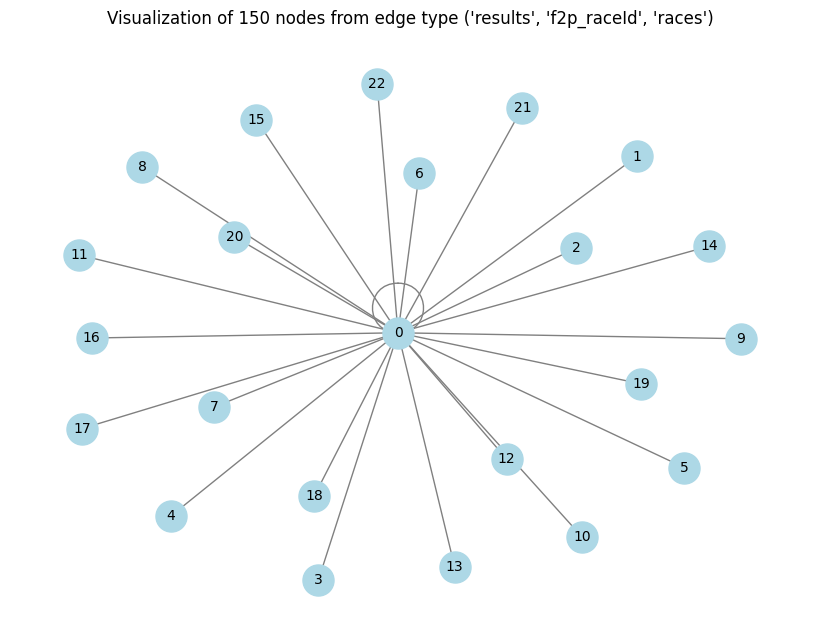

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_hetero_graph(snapshot, num_nodes=10):
    """Visualize a small portion of a heterogeneous graph with a specific edge type."""
    
    # Select the first available edge type (e.g., ('node_type1', 'relation', 'node_type2'))
    edge_type = list(snapshot.edge_index_dict.keys())[0]
    print(f"Using edge type: {edge_type}")  # Debugging

    # Extract edge index for the selected edge type
    edge_index = snapshot[edge_type].edge_index
    
    # Convert the selected subgraph to NetworkX
    nx_graph = nx.Graph()  # Create an empty NetworkX graph

    # Add edges from edge_index
    for i in range(edge_index.shape[1]):
        src = int(edge_index[0, i].item())
        dst = int(edge_index[1, i].item())
        if edge_index.numel() == 0:
            print(f"⚠️ Warning: Edge type {edge_type} has no edges! Skipping visualization.")
            return
        nx_graph.add_edge(src, dst)  # Add edge to the NetworkX graph

    # Get a subset of nodes
    sampled_nodes = list(nx_graph.nodes)[:num_nodes]
    subgraph = nx_graph.subgraph(sampled_nodes)
    
    # Plot the graph
    plt.figure(figsize=(8, 6))
    nx.draw(subgraph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(f"Visualization of {num_nodes} nodes from edge type {edge_type}")
    plt.show()

# Select the first snapshot
snapshot = data[0]  # Assuming data is a list of snapshots

# Call the function
visualize_hetero_graph(snapshot, num_nodes=150)


In [11]:
data[0]

HeteroData(
  results={
    tf=TensorFrame([23, 15]),
    time=[23],
    x=[20323, 128],
    num_nodes=20323,
  },
  standings={
    tf=TensorFrame([23, 7]),
    time=[23],
    x=[28115, 128],
    num_nodes=28115,
  },
  races={
    tf=TensorFrame([1, 7]),
    time=[1],
    x=[820, 128],
    num_nodes=820,
  },
  drivers={
    tf=TensorFrame([857, 7]),
    x=[857, 128],
  },
  constructors={
    tf=TensorFrame([211, 4]),
    x=[211, 128],
  },
  circuits={
    tf=TensorFrame([77, 8]),
    x=[77, 128],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 23],
    edge_time=[23],
  },
  (results, f2p_driverId, drivers)={
    edge_index=[2, 20323],
    edge_time=[20323],
  },
  (results, f2p_constructorId, constructors)={
    edge_index=[2, 20323],
    edge_time=[20323],
  },
  (standings, f2p_raceId, races)={
    edge_index=[2, 23],
    edge_time=[23],
  },
  (standings, f2p_driverId, drivers)={
    edge_index=[2, 28115],
    edge_time=[28115],
  },
  (races, f2p_circuitId, circuits)

col_stats_dict  contents

In [12]:
col_stats_dict

{'results': {'resultId': {<StatType.MEAN: 'MEAN'>: 11.0,
   <StatType.STD: 'STD'>: 6.6332495807108,
   <StatType.QUANTILES: 'QUANTILES'>: [0.0, 5.5, 11.0, 16.5, 22.0]},
  'raceId': {<StatType.MEAN: 'MEAN'>: 0.0,
   <StatType.STD: 'STD'>: 0.0,
   <StatType.QUANTILES: 'QUANTILES'>: [0.0, 0.0, 0.0, 0.0, 0.0]},
  'driverId': {<StatType.MEAN: 'MEAN'>: 708.3913043478261,
   <StatType.STD: 'STD'>: 71.75061831603585,
   <StatType.QUANTILES: 'QUANTILES'>: [579.0, 651.0, 704.0, 784.5, 790.0]},
  'constructorId': {<StatType.MEAN: 'MEAN'>: 116.08695652173913,
   <StatType.STD: 'STD'>: 36.82616395454196,
   <StatType.QUANTILES: 'QUANTILES'>: [49.0, 103.0, 124.0, 149.0, 152.0]},
  'number': {<StatType.MEAN: 'MEAN'>: 12.043478260869565,
   <StatType.STD: 'STD'>: 6.733939094451945,
   <StatType.QUANTILES: 'QUANTILES'>: [1.0, 7.0, 11.0, 17.5, 24.0]},
  'grid': {<StatType.MEAN: 'MEAN'>: 11.347826086956522,
   <StatType.STD: 'STD'>: 6.07638834128482,
   <StatType.QUANTILES: 'QUANTILES'>: [1.0, 6.5, 11.0,

In [13]:
print(len(data))  # Number of snapshots created

1


In [14]:
data[0]["races"].tf[10:20]

TensorFrame(
  num_cols=7,
  num_rows=0,
  numerical (3): ['circuitId', 'raceId', 'round'],
  categorical (1): ['year'],
  timestamp (2): ['date', 'time'],
  embedding (1): ['name'],
  has_target=False,
  device='cpu',
)

In [15]:
data.__sizeof__()

72

#### Edge types

In [16]:
for edge_type in data[0].edge_types:
    print(f"Edge: {edge_type}, Shape: {data[0][edge_type].edge_index.shape}")


Edge: ('results', 'f2p_raceId', 'races'), Shape: torch.Size([2, 23])
Edge: ('results', 'f2p_driverId', 'drivers'), Shape: torch.Size([2, 20323])
Edge: ('results', 'f2p_constructorId', 'constructors'), Shape: torch.Size([2, 20323])
Edge: ('standings', 'f2p_raceId', 'races'), Shape: torch.Size([2, 23])
Edge: ('standings', 'f2p_driverId', 'drivers'), Shape: torch.Size([2, 28115])
Edge: ('races', 'f2p_circuitId', 'circuits'), Shape: torch.Size([2, 820])


#### Node Types

In [17]:
for node_type in data[0].node_types:
    print(f"Node: {node_type}, Feature Shape: {data[0][node_type].tf}")


Node: results, Feature Shape: TensorFrame(
  num_cols=15,
  num_rows=23,
  numerical (14): ['constructorId', 'driverId', 'fastestLap', 'grid', 'laps', 'milliseconds', 'number', 'points', 'position', 'positionOrder', 'raceId', 'rank', 'resultId', 'statusId'],
  timestamp (1): ['date'],
  has_target=False,
  device='cpu',
)
Node: standings, Feature Shape: TensorFrame(
  num_cols=7,
  num_rows=23,
  numerical (6): ['driverId', 'driverStandingsId', 'points', 'position', 'raceId', 'wins'],
  timestamp (1): ['date'],
  has_target=False,
  device='cpu',
)
Node: races, Feature Shape: TensorFrame(
  num_cols=7,
  num_rows=1,
  numerical (3): ['circuitId', 'raceId', 'round'],
  categorical (1): ['year'],
  timestamp (2): ['date', 'time'],
  embedding (1): ['name'],
  has_target=False,
  device='cpu',
)
Node: drivers, Feature Shape: TensorFrame(
  num_cols=7,
  num_rows=857,
  numerical (1): ['driverId'],
  timestamp (1): ['dob'],
  embedding (5): ['code', 'driverRef', 'forename', 'nationality', 

In [18]:
data[0][("races", "f2p_circuitId", "circuits")]

{'edge_index': tensor([[  0,   1,   2,  ..., 817, 818, 819],
        [  8,   5,  18,  ...,  21,  17,  23]]), 'edge_time': tensor([-6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
  

This code sets up NeighborLoader for node classification or link prediction tasks on a temporal, heterogeneous graph from RelBench. It loads nodes related to drivers for training, validation, and testing across multiple time-based snapshots.

In [19]:
from relbench.modeling.graph import get_node_train_table_input
from torch_geometric.loader import NeighborLoader
import torch

loader_dict = {}
for split, table in [("train", train_table), ("val", val_table), ("test", test_table)]:
    table_input = get_node_train_table_input(table=table, task=task)
    entity_table = table_input.nodes[0]  # 'drivers'
    loader_dict[split] = []

    # Get driverIds from the table
    driver_ids = torch.tensor(table.df['driverId'].values, dtype=torch.long)

    for snapshot_idx, snapshot in enumerate(data):
        time_attr = "time" if table_input.time is not None and "time" in snapshot.get(entity_table, {}) else None
        if time_attr is None and 'dob' in snapshot.get(entity_table, {}):
            time_attr = 'dob'

        if snapshot[entity_table].num_nodes is None or snapshot[entity_table].num_nodes == 0:
            print(f"⚠️ No nodes for {entity_table}. Skipping snapshot {snapshot_idx}.")
            continue
        print(f"Available node types in snapshot {snapshot_idx}: {snapshot.node_types}")
        if entity_table not in snapshot.node_types:
            print(f"⚠️ Warning: {entity_table} not found in snapshot {snapshot_idx}. Skipping.")
            continue

        # Map driverIds to snapshot node indices (assuming 'n_id' or similar exists)
        if 'n_id' not in snapshot[entity_table]:
            print(f"⚠️ Warning: 'n_id' not found in {entity_table} for snapshot {snapshot_idx}. Assuming sequential IDs.")
            snapshot[entity_table].n_id = torch.arange(snapshot[entity_table].num_nodes)
        
        snapshot_driver_ids = snapshot[entity_table].n_id
        mask = torch.isin(snapshot_driver_ids, driver_ids)
        input_node_indices = snapshot_driver_ids[mask]

        if len(input_node_indices) == 0:
            print(f"⚠️ No matching {entity_table} nodes in snapshot {snapshot_idx} for {split} table.")
            continue

        loader = NeighborLoader(
            snapshot,
            num_neighbors=[10, 10],
            time_attr=time_attr,
            input_nodes=(entity_table, input_node_indices),
            input_time=table_input.time if time_attr is not None else None,
            transform=table_input.transform,
            batch_size=512,
            temporal_strategy="uniform",
            shuffle=(split == "train"),
            num_workers=4,
            persistent_workers=False,
        )
        if not any(loader):
            print(f"⚠️ Loader for {entity_table} in snapshot {snapshot_idx} is empty!")
        else:
            print(f"Loader for snapshot {snapshot_idx} created with {len(input_node_indices)} input nodes.")
        loader_dict[split].append(loader)

# Debug loaders
for split in ["train", "val", "test"]:
    print(f"\nChecking {split} loaders:")
    for i, snapshot_loader in enumerate(loader_dict[split]):
        print(f"  Snapshot {i}:")
        batches = list(snapshot_loader)
        print(f"    Number of batches: {len(batches)}")
        for j, batch in enumerate(batches[:2]):  # Limiting to first 2 batches
            print(f"    Batch {j}: {batch}")

Available node types in snapshot 0: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
⚠️ Warning: 'n_id' not found in drivers for snapshot 0. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 0 created with 771 input nodes.
Available node types in snapshot 0: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 0 created with 47 input nodes.
Available node types in snapshot 0: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 0 created with 56 input nodes.

Checking train loaders:
  Snapshot 0:


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([23, 15]),
    time=[23],
    x=[2906, 128],
    num_nodes=2906,
    n_id=[2906],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([23, 7]),
    time=[23],
    x=[4253, 128],
    num_nodes=4253,
    n_id=[4253],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([1, 7]),
    time=[1],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  circuits={
    tf=TensorFrame([0, 8]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 0],
    edge_time=[0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (results, f2p_driverId, drivers)={

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([23, 15]),
    time=[23],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([23, 7]),
    time=[23],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([1, 7]),
    time=[1],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  circuits={
    tf=TensorFrame([0, 8]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 0],
    edge_time=[0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (results, f2p_driverId, drivers)={
    edge_in

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([23, 15]),
    time=[23],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([23, 7]),
    time=[23],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([1, 7]),
    time=[1],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  circuits={
    tf=TensorFrame([0, 8]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 0],
    edge_time=[0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (results, f2p_driverId, drivers)={
    edge_index=[2, 237]

In [20]:
print(f"Available node types in snapshot[0]: {data[0].node_types}")


Available node types in snapshot[0]: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


Now we need our model...




## Custom TabTransformer

implementing a customized TabTransformer model that processes categorical, numerical, multi-categorical, text-embedded, and timestamp features from a TensorFrame, concatenates their embeddings, and passes them through a decoder for feature transformation.

In [21]:
from typing import Any, Dict, List
import torch
from torch import nn, Tensor
from torch.nn import L1Loss, Embedding, ModuleDict
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_frame.data.stats import StatType
from torch_geometric.typing import NodeType, EdgeType
from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, LSTMBasedTemporalEncoder
from torch_frame.nn import TabTransformer
from torch.nn import LayerNorm, Sequential, Linear, ReLU
from torch_frame import stype  # must be imported

class CustomTabTransformer(TabTransformer):
    def __init__(self, *args, num_encoder_out_dim=None, **kwargs):
        self.channels = kwargs.get("channels")
        if self.channels is None:
            raise ValueError("channels must be provided to CustomTabTransformer")
        super().__init__(*args, **kwargs)
        if hasattr(self, 'num_encoder') and self.num_encoder is not None:
            if num_encoder_out_dim is None:
                num_encoder_out_dim = 1
            self.num_proj = Linear(num_encoder_out_dim, self.channels)
        else:
            self.num_proj = None

        # Compute the total input size from all encoders.
        input_size = 0
        if hasattr(self, 'cat_encoder') and self.cat_encoder is not None:
            input_size += self.channels
        if hasattr(self, 'num_encoder') and self.num_encoder is not None:
            input_size += self.channels
        if hasattr(self, 'multi_cat_encoder') and self.multi_cat_encoder is not None:
            input_size += self.channels
        if hasattr(self, 'text_embedded_encoder') and self.text_embedded_encoder is not None:
            input_size += self.channels
        if hasattr(self, 'timestamp_encoder') and self.timestamp_encoder is not None:
            input_size += self.channels

        out_channels = kwargs["out_channels"]
        self.decoder = Sequential(
            Linear(input_size, out_channels),
            ReLU(),
            LayerNorm(out_channels),
            Linear(out_channels, out_channels),
        )
        print(f"Decoder input size: {input_size}, out_channels: {out_channels}")

    def forward(self, tf):
        xs = []
        # Process categorical features.
        if hasattr(self, 'cat_encoder') and self.cat_encoder is not None:
            if hasattr(tf, "feat_dict") and stype.categorical in tf.feat_dict:
                cat_data = tf.feat_dict[stype.categorical]
            else:
                raise ValueError("No categorical features found in the TensorFrame using stype.categorical.")
            x_cat = self.cat_encoder(cat_data)
            if x_cat.dim() == 3:
                x_cat = x_cat.mean(dim=1)
            xs.append(x_cat)
        # Process numerical features.
        if hasattr(self, 'num_encoder') and self.num_encoder is not None:
            if hasattr(tf, "feat_dict") and stype.numerical in tf.feat_dict:
                num_data = tf.feat_dict[stype.numerical]
            else:
                raise ValueError("No numerical features found in the TensorFrame using stype.numerical.")
            x_num = self.num_encoder(num_data)
            if self.num_proj is not None:
                x_num = self.num_proj(x_num)
            if x_num.dim() == 3:
                x_num = x_num.mean(dim=1)
            xs.append(x_num)
        if xs:
            x = torch.cat(xs, dim=1)
        else:
            raise ValueError("No valid features were encoded!")
        out = self.decoder(x)
        return out


## Model Definition

implementing a heterogeneous graph neural network (GNN) model that integrates tabular, temporal, and graph-based features using a CustomTabTransformer encoder, an LSTMBasedTemporalEncoder for temporal embeddings, a HeteroGraphSAGE for graph learning, and an MLP head for final predictions.

In [22]:
class Model(nn.Module):
    def __init__(
        self,
        data: List[HeteroData],
        col_to_stype_dict: Dict[str, Dict[str, 'stype']],
        col_stats_dict: Dict[str, Dict[str, Dict[StatType, Any]]],
        num_layers: int,
        channels: int,
        out_channels: int,
        aggr: str,
        norm: str,
        shallow_list: List[NodeType] = [],
        id_awareness: bool = False,
    ):
        super().__init__()
        # Build mapping: node type -> {stype: [column names]}
        node_to_col_names_dict = {}
        for node_type, col_to_stype in col_to_stype_dict.items():
            col_names_dict = {}
            for col, stype_val in col_to_stype.items():
                if stype_val not in col_names_dict:
                    col_names_dict[stype_val] = []
                col_names_dict[stype_val].append(col)
            node_to_col_names_dict[node_type] = col_names_dict

        self.encoder = HeteroEncoder(
            channels=channels,
            node_to_col_names_dict=node_to_col_names_dict,
            node_to_col_stats=col_stats_dict,
            col_to_stype_dict=col_to_stype_dict,
            torch_frame_model_cls=CustomTabTransformer,
            torch_frame_model_kwargs={
                "num_layers": num_layers,
                "out_channels": channels,
                "num_heads": 4,
                "attn_dropout": 0.1,
                "ffn_dropout": 0.1,
                "num_encoder_out_dim": 1,
            },
        )

        self.temporal_encoder = LSTMBasedTemporalEncoder(
            node_types=[node for node in data[0].node_types if "time" in data[0][node]],
            channels=channels
        )

        self.gnn = HeteroGraphSAGE(
            node_types=data[0].node_types,
            edge_types=data[0].edge_types,
            channels=channels,
            aggr=aggr,
            num_layers=num_layers,
        )

        self.head = MLP(
            channels,
            out_channels=out_channels,
            norm=norm,
            num_layers=1,
        )

        self.embedding_dict = ModuleDict({
            node: Embedding(data[0].num_nodes_dict.get(node, 0), channels)
            for node in shallow_list if data[0].num_nodes_dict.get(node, 0) > 0
        })

        self.id_awareness_emb = None
        if id_awareness:
            self.id_awareness_emb = nn.Embedding(1, channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.temporal_encoder.reset_parameters()
        self.gnn.reset_parameters()
        self.head.reset_parameters()
        for emb in self.embedding_dict.values():
            nn.init.normal_(emb.weight, std=0.1)
        if self.id_awareness_emb is not None:
            self.id_awareness_emb.reset_parameters()
                    
    def forward(self, batch: HeteroData, entity_table: NodeType) -> Tensor:
        seed_time = batch.time_dict.get(entity_table, None)
        # Encode features from each node type that has a TensorFrame.
        x_dict = self.encoder({
            node_type: batch[node_type].tf 
            for node_type in batch.node_types if hasattr(batch[node_type], 'tf')
        })
        # Add shallow embeddings.
        for node_type, emb in self.embedding_dict.items():
            if node_type not in x_dict or x_dict[node_type] is None:
                n = batch[node_type].num_nodes if hasattr(batch[node_type], 'num_nodes') else 0
                device = next(self.parameters()).device
                x_dict[node_type] = emb(torch.arange(n, device=device))
            else:
                n = batch[node_type].num_nodes if hasattr(batch[node_type], 'num_nodes') else x_dict[node_type].size(0)
                device = next(self.parameters()).device
                emb_tensor = emb(torch.arange(n, device=device))
                if x_dict[node_type].size(0) < n:
                    pad = torch.zeros((n - x_dict[node_type].size(0), x_dict[node_type].size(1)), device=device)
                    x_dict[node_type] = torch.cat([x_dict[node_type], pad], dim=0)
                x_dict[node_type] = x_dict[node_type] + emb_tensor

        # Ensure each node type has a feature tensor with expected number of rows.
        for node_type in batch.node_types:
            if not hasattr(batch[node_type], 'num_nodes'):
                continue
            expected = batch[node_type].num_nodes
            if node_type not in x_dict or x_dict[node_type] is None:
                device = next(self.parameters()).device
                x_dict[node_type] = torch.zeros((expected, 128), device=device)
            else:
                if x_dict[node_type].size(0) < expected:
                    pad = torch.zeros((expected - x_dict[node_type].size(0), x_dict[node_type].size(1)),
                                      device=x_dict[node_type].device)
                    x_dict[node_type] = torch.cat([x_dict[node_type], pad], dim=0)
        
        # Optionally apply temporal encoding.
        rel_time_dict = {}
        if seed_time is not None:
            rel_time_dict = self.temporal_encoder(x_dict, batch.time_dict, batch.batch_dict)
        for node_type, rel_time in rel_time_dict.items():
            if node_type in x_dict:
                x_dict[node_type] = x_dict[node_type] + rel_time
            else:
                x_dict[node_type] = rel_time

        # Filter out edge relations with empty indices.
        filtered_edge_index_dict = {key: value for key, value in batch.edge_index_dict.items() if value.numel() > 0}
        
        # IMPORTANT: Only keep node types expected by the GNN.
        expected_node_types = set(self.gnn.norms[0].keys())
        x_dict = {k: v for k, v in x_dict.items() if k in expected_node_types}

        # Pass features through the GNN.
        x_dict = self.gnn(x_dict, filtered_edge_index_dict)
        n = seed_time.size(0) if seed_time is not None else x_dict[entity_table].size(0)
        return self.head(x_dict[entity_table][:n])



We also need standard train/test loops

## # Instantiate model, optimizer, loss, etc.

In [23]:
model = Model(
    data=data,
    col_to_stype_dict=col_to_stype_dict,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
    id_awareness=True,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = L1Loss()
epochs = 10

KeyError: 'qualifying'

## Train and test codes

In [ ]:
from tqdm import tqdm

def train() -> float:
    model.train()
    loss_accum = count_accum = 0
    for snapshot_loader in tqdm(loader_dict["train"]):
        for batch in snapshot_loader:
            batch = batch.to(device)
            print(f"Batch node types: {batch.node_types}")
            # Robust check for entity_table
            if task.entity_table not in batch.node_types:
                print(f"Warning: {task.entity_table} not in batch.node_types. Checking batch keys: {list(batch.keys())}")
                if task.entity_table not in batch:
                    raise ValueError(f"Entity table {task.entity_table} missing in batch!")
            
            optimizer.zero_grad()
            
            pred = model(batch, task.entity_table)
            pred = pred.view(-1) if pred.size(1) == 1 else pred

            # Ensure y is present
            if 'y' not in batch[task.entity_table]:
                raise ValueError(f"'y' missing in {task.entity_table} for batch!")
            
            loss = loss_fn(pred.float(), batch[task.entity_table].y.float())
            loss.backward()
            optimizer.step()

            loss_accum += loss.detach().item() * pred.size(0)
            count_accum += pred.size(0)

    return loss_accum / count_accum if count_accum > 0 else float("inf")
@torch.no_grad()
def test(loader):
    model.eval()
    pred_list = []
    node_ids_list = []  # To store node indices
    
    for snapshot_loader in loader:
        for batch in snapshot_loader:
            batch = batch.to(device)
            pred = model(batch, task.entity_table)
            pred = pred.view(-1) if pred.size(1) == 1 else pred
            pred_list.append(pred.detach().cpu())

            # Collect node indices
            node_ids_list.append(batch[task.entity_table].n_id.cpu())

    if not pred_list:
        raise ValueError("No predictions generated. Check loader or model forward pass.")

    pred_all = torch.cat(pred_list, dim=0).numpy()
    node_ids_all = torch.cat(node_ids_list, dim=0).numpy()

    # Map predictions to `driverId` values in val_table
    val_driver_ids = val_table.df["driverId"].values  # Get driver IDs from validation table
    pred_dict = dict(zip(node_ids_all, pred_all))  # Create a mapping {node_id: prediction}

    # Retrieve predictions in the order of driver IDs in val_table
    val_pred_filtered = [pred_dict.get(driver_id, np.nan) for driver_id in val_driver_ids]

    # Ensure no NaNs are present (this means missing driverId was found)
    val_pred_filtered = np.array(val_pred_filtered)
    if np.isnan(val_pred_filtered).any():
        raise ValueError("Some driverIds from val_table were not found in predictions!")

    return val_pred_filtered


Now we are ready to train!

In [ ]:
print("=== Training Epoch ===")
for epoch in range(epochs):
    train_loss = train()  # your train() function
    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")
    
    # Evaluate on validation set.
    val_pred = test(loader_dict["val"])  # your test() function
    print(f"Epoch {epoch+1} Validation Prediction Shape: {val_pred.shape}")
    
    # Optionally, print a few sample predictions.
    print("Sample Predictions:", val_pred[:5])
    
    # Optionally, print a summary of one batch.
    for batch in loader_dict["val"]:
        print("Batch Summary:")
        for node in batch.data.node_types:
            print(f"  {node}: num_nodes = {batch.data[node].num_nodes}")
        print("Edge Index Summary:")
        for edge_type, edge_index in batch.data.edge_index_dict.items():
            print(f"  {edge_type}: shape = {edge_index.shape}")
        break  # print summary for first batch only

# Test the model.
test_pred = test(loader_dict["test"])


In [ ]:
print("Sample Predictions:", val_pred[:5])


In [ ]:
print("Sample Predictions:", torch.tensor(val_pred[:8]).cpu().detach().numpy())


In [ ]:
import copy
import math

state_dict = None
best_val_metric = -math.inf if higher_is_better else math.inf

print("=== Training Epoch ===")
for epoch in range(1, epochs + 1):
    train_loss = train()  # Train the model
    print(f"Epoch {epoch:02d}, Training Loss: {train_loss:.4f}")

    # Evaluate on validation set
    val_pred = test(loader_dict["val"])
    val_metrics = task.evaluate(val_pred, val_table)
    print(f"Epoch {epoch:02d}, Val Metrics: {val_metrics}")

    # Update best model checkpoint
    if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
        not higher_is_better and val_metrics[tune_metric] < best_val_metric
    ):
        best_val_metric = val_metrics[tune_metric]
        state_dict = copy.deepcopy(model.state_dict())

# Load the best model
model.load_state_dict(state_dict)

# Evaluate on the validation set with the best model
val_pred = test(loader_dict["val"])
val_metrics = task.evaluate(val_pred, val_table)
print(f"Best Val Metrics: {val_metrics}")

# Evaluate on the test set
test_pred = test(loader_dict["test"])
test_metrics = task.evaluate(test_pred)
print(f"Best Test Metrics: {test_metrics}")
